In [39]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import root_mean_squared_error
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.family'] = "Arial"
# 保证能在Ai内编辑
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

### 定义函数


In [86]:
def calculate_error(y_true, y_pred):
    """
    计算预测值和真实值之间的相关系数（R）、平均偏差误差（MBE）、
    百分比平均偏差误差（%MBE）、均方根误差（RMSE）和百分比均方根误差（%RMSE）。

    参数:
    y_true: np.array, 真实值
    y_pred: np.array, 预测值

    返回:
    dict: 包含R, MBE, %MBE, RMSE, %RMSE的字典
    """
    Uo = 5
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # 相关系数 R
    R, _ = pearsonr(y_true, y_pred)
    # 计算误差
    error = y_pred - y_true
    # 平均偏差误差（MBE）
    MBE = np.mean(error)
    # 百分比平均偏差误差（%MBE）
    MBE_percent = (MBE / np.mean(y_true)) * 100
    # 均方根误差（RMSE）
    RMSE = root_mean_squared_error(y_true, y_pred)
    # 百分比均方根误差（%RMSE）
    RMSE_percent = (RMSE / np.sqrt(np.mean(y_true**2))) * 100
    # U95
    U95 = np.sqrt(Uo**2 + MBE_percent**2 + RMSE_percent**2)

    # return U95
    return {
        "R": R,
        "MBE": MBE,
        # "%MBE": MBE_percent,
        "RMSE": RMSE,
        # "%RMSE": RMSE_percent,
        "U95": U95
    }

def groupby_station_error(database, save_file):
    # 按站点分组计算指标
    # error = database.groupby('originalID').apply(lambda x: calculate_error(x['Observation'], x['Model'])["RMSE"], include_groups=False).reset_index(name="RMSE")
     # 按站点分组计算 RMSE、MBE 和 R
    error_dict = database.groupby('originalID').apply(lambda x: calculate_error(x['Observation'], x['Model']), include_groups=False)
    # 将字典转换为 DataFrame
    error = pd.DataFrame(error_dict.tolist(), index=error_dict.index)

    # 添加坐标
    error = pd.merge(error, station, on="originalID", how="left")
    # 保存为excel
    error.to_excel(save_file)
    print(f"保存成功---{save_file}")
    return error

def groupby_lat_error(error_database):
    error_database["lat_group"] = pd.cut(error_database["lat"], bins=range(-90, 91, 10))
    error_mean = error_database.groupby("lat_group", observed=False)[["R", "MBE", "RMSE", "U95"]].mean()
    return error_mean

### 读取数据

In [60]:
# 读取站点数据
station = pd.read_excel(r"D:\PhD\data\station_all_v3.xlsx")[["originalID", "lat", "lon"]]
station["originalID"] = station["originalID"].astype(str)

# 读取数据库
database = pd.read_feather(r'D:\PhD\data\station_feather\station_data_all_v3.feather').rename(columns={'daily_radiation':'Observation'})
database["originalID"] = database["originalID"].astype(str)
models_name = ['ISCCP-ITP', 'GLASS', 'ERA5', 'MERRA-2', 'SSP245', 'SSP585']

# 逐日数据
database_ISCCP_d  = database[~database['ISCCP-ITP'].isna()][['originalID', 'Observation','ISCCP-ITP']].rename(columns={'ISCCP-ITP':'Model'}).reset_index(drop=True)
database_GLASS_d  = database[~database['GLASS'].isna()][['originalID', 'Observation','GLASS']].rename(columns={'GLASS':'Model'}).reset_index(drop=True)
database_ERA5_d  = database[~database['ERA5'].isna()][['originalID', 'Observation','ERA5']].rename(columns={'ERA5':'Model'}).reset_index(drop=True)
database_MERRA2_d = database[['originalID', 'Observation','MERRA2']].rename(columns={'MERRA2':'Model'}).reset_index(drop=True)
database_SSP245_d = database[~database['SSP245'].isna()][['originalID', 'Observation','SSP245']].rename(columns={'SSP245':'Model'}).reset_index(drop=True)
database_SSP585_d = database[~database['SSP585'].isna()][['originalID', 'Observation','SSP585']].rename(columns={'SSP585':'Model'}).reset_index(drop=True)

In [79]:
error_ISCCP_d  =  groupby_station_error(database_ISCCP_d, r"D:\PhD\UCAS\Undergraduate\Projects\Python\datas\error_ISCCP_d.xlsx")
error_GLASS_d  =  groupby_station_error(database_GLASS_d, r"D:\PhD\UCAS\Undergraduate\Projects\Python\datas\error_GLASS_d.xlsx")
error_ERA5_d   =   groupby_station_error(database_ERA5_d, r"D:\PhD\UCAS\Undergraduate\Projects\Python\datas\error_ERA5_d.xlsx")
error_ERA5_d["R"].fillna(0, inplace=True)
error_MERRA2_d = groupby_station_error(database_MERRA2_d, r"D:\PhD\UCAS\Undergraduate\Projects\Python\datas\error_MERRA2_d.xlsx")
error_SSP245_d = groupby_station_error(database_SSP245_d, r"D:\PhD\UCAS\Undergraduate\Projects\Python\datas\error_SSP245_d.xlsx")
error_SSP585_d = groupby_station_error(database_SSP585_d, r"D:\PhD\UCAS\Undergraduate\Projects\Python\datas\error_SSP585_d.xlsx")



C:\Users\Xvwenchao\AppData\Local\Temp\ipykernel_18952\1955898137.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  error_ERA5_d["R"].fillna(0, inplace=True)


### 计算纬度每10°的误差的平均值

In [88]:
error_ISCCP_d_latgroup = groupby_lat_error(error_ISCCP_d)
error_GLASS_d_latgroup = groupby_lat_error(error_GLASS_d)
error_ERA5_d_latgroup = groupby_lat_error(error_ERA5_d)
error_MERRA2_d_latgroup = groupby_lat_error(error_MERRA2_d)
error_SSP245_d_latgroup = groupby_lat_error(error_SSP245_d)
error_SSP585_d_latgroup = groupby_lat_error(error_SSP585_d)

### 06070809绘图：纬度折线图

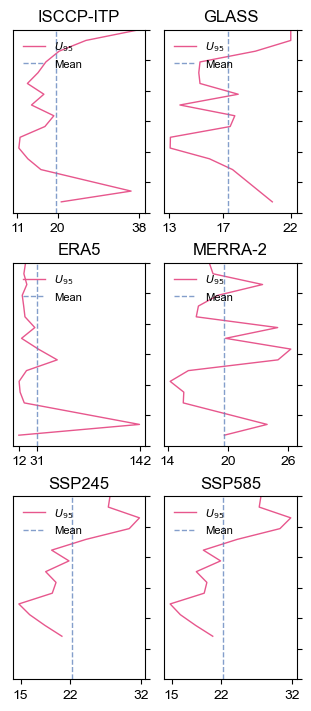

In [170]:
# 绘图
models = [error_ISCCP_d_latgroup, error_GLASS_d_latgroup, error_ERA5_d_latgroup, error_MERRA2_d_latgroup, error_SSP245_d_latgroup, error_SSP585_d_latgroup]
models_name = ['ISCCP-ITP', 'GLASS', 'ERA5', 'MERRA-2', 'SSP245', 'SSP585']
axs_num = ['a', 'b', 'c', 'd', 'e', 'f']
fig, axs = plt.subplots(3, 2, constrained_layout=True, figsize=(3, 7))
i = 1
for model, ax, model_name, ax_num in zip(models, axs.flatten(), models_name, axs_num):
    # 标题
    ax.set_title(model_name, fontsize=12)

    data = model["U95"]
    # 对 NaN 值进行线性插值
    interpolated_data = data.interpolate()

    mean_value = np.mean(interpolated_data) # 平均的平均
    # 生成纬度数组（Y轴）
    latitudes = np.linspace(-90, 90, data.shape[0])

    # 绘制折线图
    ax.plot(interpolated_data, latitudes, color='#e7578d', linewidth=1)
    # 添加平均值线 灰色#b2c1c8 蓝色#6586bf 粉红色#e7578d 浅粉色#dbafc9
    ax.axvline(x=mean_value, color='#6586bf', linestyle='--', alpha=0.8, linewidth=1)




    ax.yaxis.tick_right() # 将 Y 轴设置在右侧
    ax.set_ylim(-90, 90) # 设置折线图的 Y 轴范围与地图一致
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90]) # 设置Y轴刻度
    ax.set_yticklabels([]) # 隐藏Y轴刻度标签
    ax.tick_params(axis='both',direction="out", labelsize=10) # 刻度线朝内

    # 设置 X 轴刻度标签为数据的最低值、平均值、最高值
    xticks = [round(np.nanmin(interpolated_data), 0), round(mean_value, 0), round(np.nanmax(interpolated_data), 0)]
    ax.set_xticks(xticks)


    # 添加图例
    ax.legend(['$U_{95}$', 'Mean'], loc='upper left', fontsize=8, frameon=False)


    i += 1


# fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=1), cmap="Spectral_r"), ax=axs, pad=0.01, orientation='vertical', aspect=30, alpha=0.8, label='Density')
# 保存为矢量
# fig.savefig('figs/09-1纬度折线图-U95.pdf', format='pdf', dpi=1000, bbox_inches='tight')

### 060708绘图转ArcGIS，此处用于计算分级色彩范围

In [178]:
# concated = pd.concat([error_ISCCP_d, error_GLASS_d, error_ERA5_d, error_MERRA2_d, error_SSP245_d, error_SSP585_d], axis=0)
column_name = 'U95'

# 使用 qcut 将数据划分为5组
concated['group'], bins = pd.qcut(concated[column_name], 5, retbins=True, duplicates='drop')

# 输出每组的范围
print(column_name + "每组数据的范围：")
for i in range(len(bins) - 1):
    print(f"组 {i+1}: {bins[i]} - {bins[i+1]}")

# 计算每个组中的记录数
group_counts = concated['group'].value_counts().sort_index()

# 输出每个组中的记录数
print("\n每组中的记录数：")
for group, count in group_counts.items():
    print(f"组 {group}: {count} 条记录")

U95每组数据的范围：
组 1: 7.321673908894058 - 13.477458437412148
组 2: 13.477458437412148 - 15.930704615785631
组 3: 15.930704615785631 - 18.788802065641274
组 4: 18.788802065641274 - 23.43590635437789
组 5: 23.43590635437789 - 370.43023503351867

每组中的记录数：
组 (7.321, 13.477]: 626 条记录
组 (13.477, 15.931]: 626 条记录
组 (15.931, 18.789]: 625 条记录
组 (18.789, 23.436]: 626 条记录
组 (23.436, 370.43]: 626 条记录


### 06070809绘图：绘制各分级色彩组占比饼图

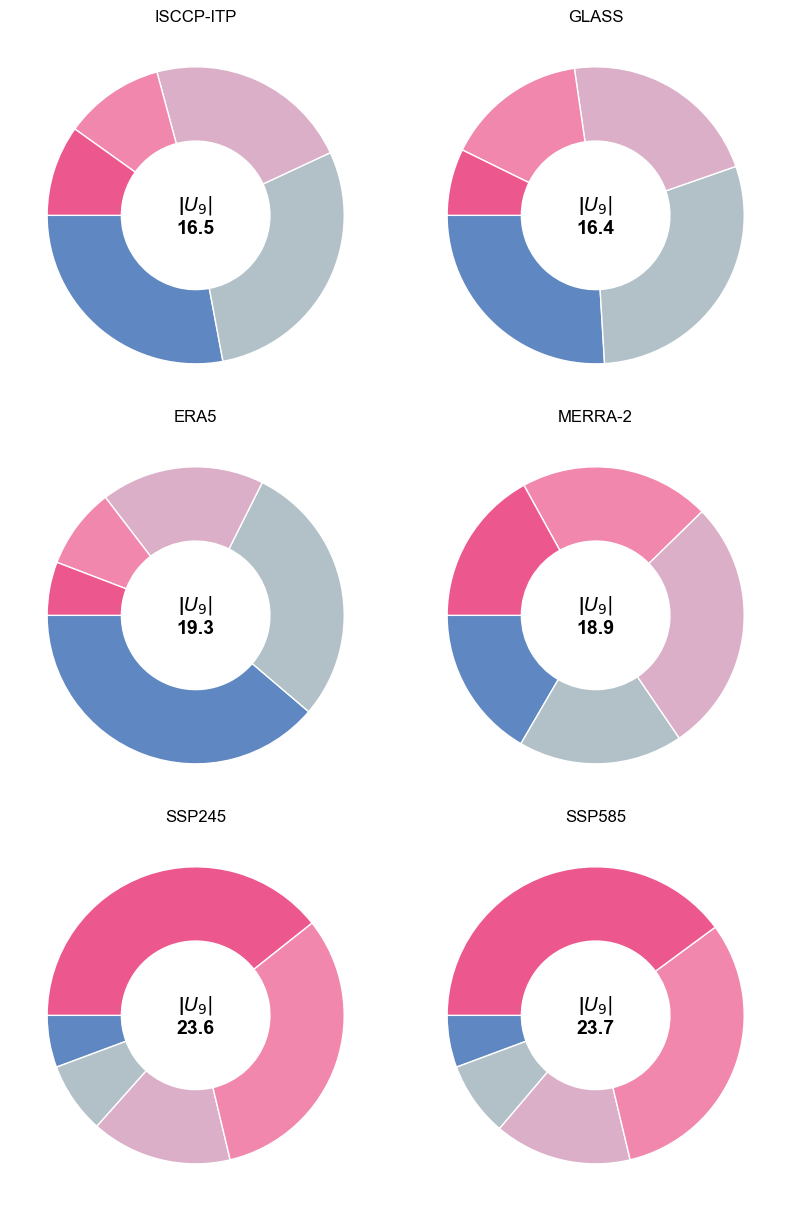

In [188]:
# 绘图
models = [error_ISCCP_d, error_GLASS_d, error_ERA5_d, error_MERRA2_d, error_SSP245_d, error_SSP585_d]
models_name = ['ISCCP-ITP', 'GLASS', 'ERA5', 'MERRA-2', 'SSP245', 'SSP585']
axs_num = ['a', 'b', 'c', 'd', 'e', 'f']
fig, axs = plt.subplots(3, 2, constrained_layout=True, figsize=(8, 12))
i = 1
for model, ax, model_name, ax_num in zip(models, axs.flatten(), models_name, axs_num):
    # 计算指标的平均值
    error_mean = model[column_name].mean()
    # 使用 pd.cut 对 df[column_name] 进行分箱，根据 bins 边界值
    model['colorGroup'] = pd.cut(model[column_name], bins=bins, labels=False)

    # 统计每个 colorGroup 中的记录数
    color_group_counts = model['colorGroup'].value_counts().sort_index()
    print(model_name, color_group_counts)

    # 设置饼图的颜色
    colors = ['#5f87c1','#b2c1c8','#dcafc9','#f187ad','#ec578d']
    # 设置空心饼图的属性
    wedgeprops = {'width': 0.5, 'edgecolor': 'w'}
    # 绘制饼图
    ax.pie(color_group_counts, colors=colors, startangle=180, wedgeprops=wedgeprops)
    # 在饼图中心添加 error_mean
    ax.text(0, 0, f'|$U_{9}|$\n{error_mean:.1f}', horizontalalignment='center', verticalalignment='center', fontsize=14, color='black', fontweight='bold')

    # 标题
    ax.set_title(model_name, fontsize=12)
    i += 1

# 保存为矢量
# fig.savefig('figs/09-2分级色彩饼图-U95.pdf', format='pdf', dpi=1000, bbox_inches='tight')